In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### imports

In [2]:
print(__doc__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.svm import SVC
from collections import Counter
from scipy.stats import entropy as calculate_entropy
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Automatically created module for IPython interactive environment


### utilities

In [3]:
def sigmoid(x):
#     return x / (x+1)
    return 1 / (1 + (np.e**-x))

def infer_topic(doc_vector, topic_word_distr, threshold=None):
    doc_topic_word_distr = topic_word_distr.copy()
    
    if threshold is None:
        doc_word_freq_norm = doc_vector
        
    else:
        doc_word_freq_norm = (doc_vector > threshold).astype(int)
   
    for label_class in label_classes:
        doc_topic_word_distr[label_class] *= doc_word_freq_norm
    
    
    doc_topic = np.max(doc_topic_word_distr).idxmax()
    return doc_topic_word_distr, doc_topic

### load dataset

In [4]:
# total number of samples needed
datasize = 1000

# retrieve dataset
docs = fetch_20newsgroups(subset='train', shuffle=False, remove=('headers', 'footers', 'quotes'))
docs, old_labels, classes = docs.data[:datasize], docs.target[:datasize], docs.target_names

### clean dataset

In [5]:
# clean out the new line characters from text in docs
def clean_doc(doc):
    ''' remove unwanter characters line new line '''

    unwanted_chrs = [')', '(', '{', '}', '\t', '\n', '\r', "'", '"', "!"]
    doc = doc.lower()
    for unwanted_chr in unwanted_chrs:
        doc = doc.replace(unwanted_chr, ' ')

    return doc.strip()

In [6]:
labels = []
clean_docs = []

# the new classes
# label_classes = ['sci/comp', 'other']
label_classes = list(set([x.split('.')[0] for x in classes]))

for index, doc in enumerate(docs):
    cd = clean_doc(doc)
    
    if cd and not cd.isspace():
        clean_docs.append(cd)
        
        cl = classes[old_labels[index]]
#         if cl in ['sci', 'comp']:
#             labels.append(0)
            
#         else:
#             labels.append(1)
        labels.append(label_classes.index(cl.split('.')[0]))

labels = np.array(labels)   
print(clean_docs[0])

morgan and guzman will have era s 1 run higher than last year, and  the cubs will be idiots and not pitch harkey as much as hibbard.  castillo won t be good  i think he s a stud pitcher


In [7]:
print(f"there are {len(clean_docs)} docs and {len(label_classes)} classes: {label_classes}")

there are 973 docs and 7 classes: ['misc', 'alt', 'talk', 'rec', 'comp', 'sci', 'soc']


### count words

In [8]:
# initialize the count vectorizer
count_vectorizer = CountVectorizer()
# count_vectorizer = TfidfVectorizer()

# fit it to dataset
train_docs, test_docs, train_labels, test_labels = train_test_split(clean_docs, labels, test_size=.33, random_state=42)
count_vectorizer.fit(train_docs)
vocabulary = count_vectorizer.get_feature_names()

print("word_count is", len(vocabulary))

word_count is 14988


### Prepare Datatset

In [9]:
# create doc count vectors
train_doc_vectors = count_vectorizer.transform(train_docs).toarray()
# train_doc_vectors = (train_doc_vectors > 0).astype('float')
train_doc_vectors = normalize(train_doc_vectors, norm="l1", axis=1)
# train_doc_vectors = normalize(train_doc_vectors, norm="l1", axis=0)

test_doc_vectors = count_vectorizer.transform(test_docs).toarray()
# test_doc_vectors = (test_doc_vectors > 0).astype('float')
test_doc_vectors = normalize(test_doc_vectors, norm="l1", axis=1)
# test_doc_vectors = normalize(test_doc_vectors, norm="l1", axis=0)

print(f"{len(train_labels)} train_docs, {len(test_labels)} test docs")

651 train_docs, 322 test docs


In [10]:
document_word_frequency = pd.DataFrame(train_doc_vectors, columns=count_vectorizer.get_feature_names())
document_word_frequency["__labels__"] = train_labels

print("document_word_frequency shape is", document_word_frequency.shape)

document_word_frequency shape is (651, 14989)


In [11]:
print(f"there are {len(clean_docs)} docs and {len(label_classes)} classes")

there are 973 docs and 7 classes


In [12]:
document_word_frequency.head()

,00,000,0000,00000000,00000000b,00000001,00000001b,00000010,00000010b,00000011,...,zombo,zone,zoom,zooming,zubov,zum,zx,zx900a,zzz,__labels__
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


### Decision Model

0.0000 <= computer <= 0.0002, relation = 0.1226, topic = comp


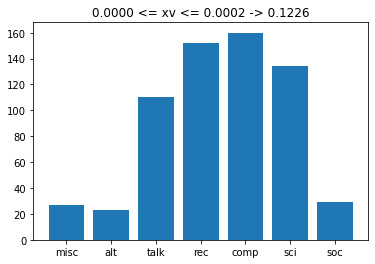

0.0011 <= computer <= 0.0012, relation = 0.2500, topic = rec


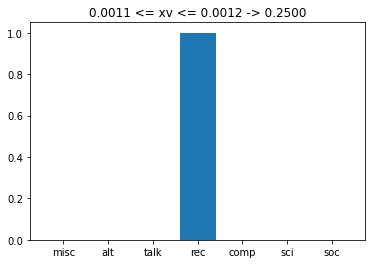

0.0017 <= computer <= 0.0018, relation = 0.2500, topic = sci


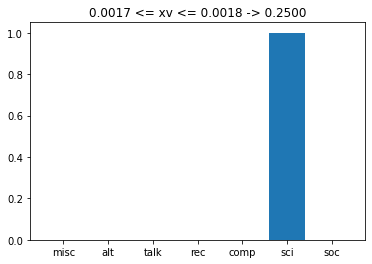

0.0032 <= computer <= 0.0033, relation = 0.2500, topic = comp


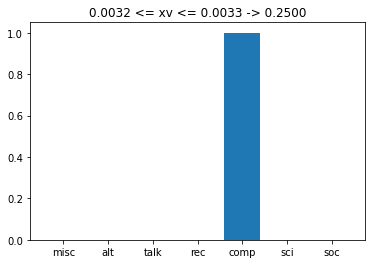

0.0035 <= computer <= 0.0036, relation = 0.2500, topic = soc


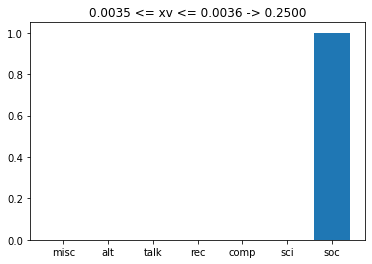

0.0044 <= computer <= 0.0045, relation = 0.2075, topic = comp


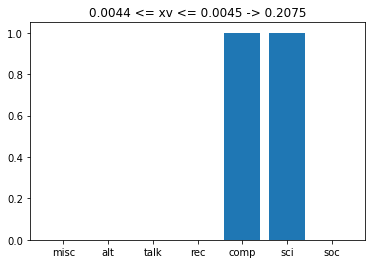

0.0055 <= computer <= 0.0056, relation = 0.2500, topic = comp


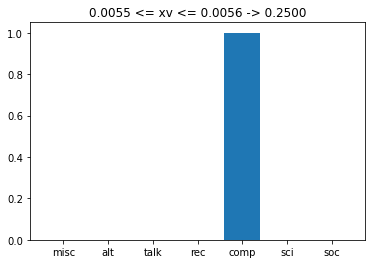

0.0070 <= computer <= 0.0071, relation = 0.2500, topic = misc


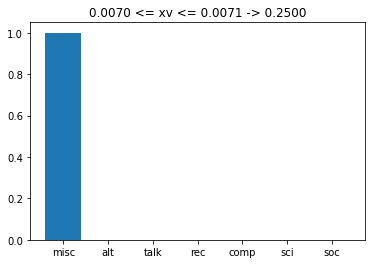

0.0074 <= computer <= 0.0076, relation = 0.2500, topic = comp


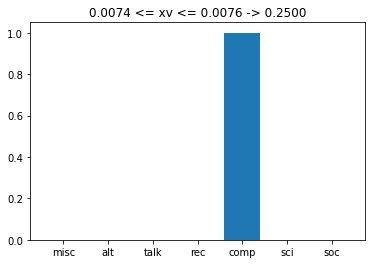

0.0085 <= computer <= 0.0086, relation = 0.2500, topic = comp


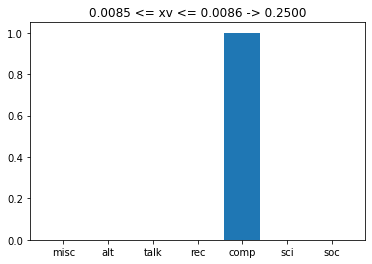

0.0086 <= computer <= 0.0088, relation = 0.2500, topic = sci


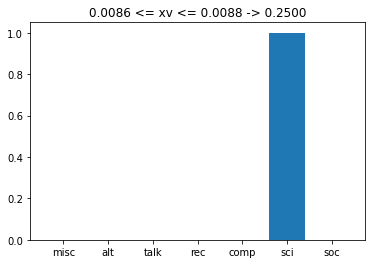

0.0094 <= computer <= 0.0095, relation = 0.2500, topic = misc


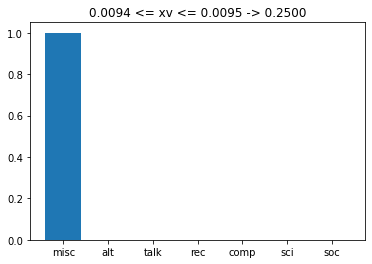

0.0127 <= computer <= 0.0129, relation = 0.3080, topic = sci


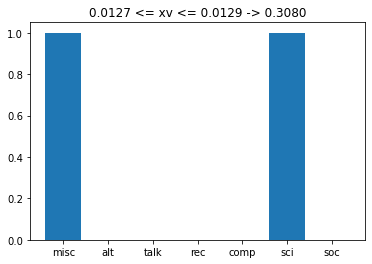

0.0135 <= computer <= 0.0136, relation = 0.2500, topic = comp


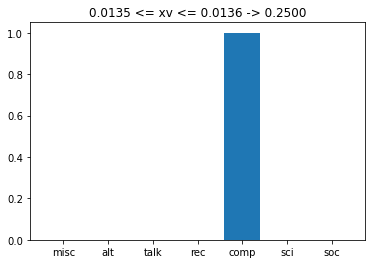

In [26]:
N = 100

word = "computer"
word_index = vocabulary.index(word)

xv = train_doc_vectors[:, word_index]
mesh = np.linspace(xv.min(), xv.max(), N+1)

for i in range(1, N):
    a, b = mesh[i-1:i+1]

    sub_data = train_labels[(xv >= a) & (xv <= b)]
    size = len(sub_data)

    count = Counter(sub_data)
    clx, values = [], []

    for index, label in enumerate(label_classes):
        clx.append(label)
        values.append(count.get(index, 0))

    if not any(values):
        continue

    relation = (1 - sigmoid(calculate_entropy(values))) * sigmoid(sub_data.std())
    topic = count.most_common(1)[0][0]
    print(f"{a:.4f} <= {word} <= {b:.4f}, relation = {relation:.4f}, topic = {label_classes[topic]}")
    
    plt.title(f"{a:.4f} <= xv <= {b:.4f} -> {relation:.4f}")
    plt.bar(clx, values)
    plt.show()

In [27]:
N = 100

model = {}

for word_index in tqdm(range(len(vocabulary))):
    word = vocabulary[word_index]
    
    #the decision model
    model[word] = {}
    
    xv = train_doc_vectors[:, word_index]
    mesh = np.linspace(xv[xv > 0].min(), xv.max(), N+1)

    for i in range(1, N):
        a, b = mesh[i-1:i+1]
        
        sub_data = train_labels[(xv >= a) & (xv <= b)]
        size = len(sub_data)
        
        count = Counter(sub_data)
        clx, values = [], []
        
        for index, label in enumerate(label_classes):
            clx.append(label)
            values.append(count.get(index, 0))

        if not any(values):
            continue

        relation = (1 - sigmoid(calculate_entropy(values))) * (size / (size + 1))
        topic = count.most_common(1)[0][0]
#         print(f"{a:.4f} <= {word} <= {b:.4f}, relation = {relation:.4f}, topic = {label_classes[topic]}")
        
        model[word][tuple([a, b])] = {"topic":topic, "relation":relation}

In [21]:
score_train = 0
misclassified_train = []
not_classified_train = []
num_of_classified_train = 0

for doc_index in tqdm(range(len(train_doc_vectors))):
    train_doc_vector = train_doc_vectors[doc_index]
    
    min_relation = 0
    min_rng = (0, 0)
    min_topic = None


    for word_index, word_value in enumerate(train_doc_vector):
        relation = topic = None
        word = vocabulary[word_index]
                
        for rng in model[word]:
            if rng[0] <= word_value <= rng[1]:
                topic = model[word][rng]['topic']
                relation = model[word][rng]['relation']
                break
        
        if topic is None:
            continue
        
        if relation >= min_relation:
            min_relation = relation
            min_topic = topic
            min_rng = rng
    
    if min_topic is None:
        not_classified_train.append(doc_index)
        continue
    
    if min_topic != train_labels[doc_index]:
        misclassified_train.append(doc_index)
        
    score_train += int(min_topic == train_labels[doc_index])
    num_of_classified_train += 1
        
train_accuracy = score_train * 100 / num_of_classified_train
print(f"train_accuracy = {train_accuracy}%, {len(misclassified_train)} misclassified, {len(not_classified_train)} not_classified!")


train_accuracy = 90.3875968992248%, 62 misclassified, 6 not_classified!


In [24]:
score_test = 0
misclassified_test = []
not_classified_test = []
num_of_classified_test = 0

for doc_index in tqdm(range(len(test_doc_vectors))):
    test_doc_vector = test_doc_vectors[doc_index]
    
    min_relation = 0
    min_rng = (0, 0)
    min_topic = None


    for word_index, word_value in enumerate(test_doc_vector):
        relation = topic = None
        word = vocabulary[word_index]
                
        for rng in model[word]:
            if rng[0] <= word_value <= rng[1]:
                topic = model[word][rng]['topic']
                relation = model[word][rng]['relation']
                break
        
        if topic is None:
            continue
        
        if relation >= min_relation:
            min_relation = relation
            min_topic = topic
            min_rng = rng
    
    if min_topic is None:
        not_classified_test.append(doc_index)
        continue
    
    if min_topic != test_labels[doc_index]:
        misclassified_test.append(doc_index)
        
    score_test += int(min_topic == test_labels[doc_index])
    num_of_classified_test += 1
        
test_accuracy = score_test * 100 / num_of_classified_test
print(f"test_accuracy = {test_accuracy}%, {len(misclassified_test)} misclassified, {len(not_classified_test)} not_classified!")


test_accuracy = 22.903225806451612%, 239 misclassified, 12 not_classified!


In [25]:
training = False
misclassified = True

if training:
    tlabels = train_labels
    tdoc_vectors = train_doc_vectors
    array = misclassified_train if misclassified else not_classified_train
        
else:
    tlabels = test_labels
    tdoc_vectors = test_doc_vectors
    
    array = misclassified_test if misclassified else not_classified_test

for doc_index in tqdm(array):
    tdoc_vector = tdoc_vectors[doc_index]
    
    min_relation = 0
    min_rng = (0, 0)
    min_topic = min_word = None


    for word_index, word_value in enumerate(tdoc_vector):
        relation = 0
        topic = None
        word = vocabulary[word_index]
                
        for rng in model[word]:
            if rng[0] <= word_value <= rng[1]:
                topic = model[word][rng]['topic']
                relation = model[word][rng]['relation']
                break
        
#         if word_value > 0:
#             pt = None if topic is None else label_classes[topic]
#             print(f"{rng[0]:.4f} <= [{word:10s}:{word_value:.4f}] <= {rng[1]:.4f}, relation = {relation:.4f}, predicted_topic = {pt}, actual_topic = {label_classes[tlabels[doc_index]]}")
    
        
        if topic is None:
            continue
        
        if relation >= min_relation:
            min_relation = relation
            min_topic = topic
            min_rng = rng
            min_word = word
            
            pt = None if topic is None else label_classes[topic]
            print(f"{rng[0]:.4f} <= {word} <= {rng[1]:.4f}, relation = {relation:.4f}, predicted_topic = {pt}, actual_topic = {label_classes[tlabels[doc_index]]}")
    
    if min_topic is None:
        continue
        
    pt = None if min_topic is None else label_classes[min_topic]
    print(f"==> {min_rng[0]:.4f} <= {min_word} <= {min_rng[1]:.4f}, relation = {min_relation:.4f}, predicted_topic = {pt}, actual_topic = {label_classes[tlabels[doc_index]]}\n")

0.0081 <= 20 <= 0.0086, relation = 0.2500, predicted_topic = comp, actual_topic = comp
0.0079 <= can <= 0.0088, relation = 0.2880, predicted_topic = comp, actual_topic = comp
0.0084 <= far <= 0.0086, relation = 0.3750, predicted_topic = rec, actual_topic = comp
==> 0.0084 <= far <= 0.0086, relation = 0.3750, predicted_topic = rec, actual_topic = comp

0.0204 <= all <= 0.0209, relation = 0.1875, predicted_topic = alt, actual_topic = comp
0.0197 <= any <= 0.0205, relation = 0.2090, predicted_topic = comp, actual_topic = comp
0.0201 <= have <= 0.0210, relation = 0.2152, predicted_topic = rec, actual_topic = comp
0.0201 <= mac <= 0.0209, relation = 0.2500, predicted_topic = comp, actual_topic = comp
0.0200 <= other <= 0.0205, relation = 0.2500, predicted_topic = sci, actual_topic = comp
==> 0.0200 <= other <= 0.0205, relation = 0.2500, predicted_topic = sci, actual_topic = comp

0.0372 <= for <= 0.0386, relation = 0.2324, predicted_topic = sci, actual_topic = sci
0.0380 <= used <= 0.0385, 


0.0244 <= about <= 0.0260, relation = 0.2222, predicted_topic = sci, actual_topic = misc
0.0245 <= are <= 0.0259, relation = 0.2430, predicted_topic = talk, actual_topic = misc
0.0252 <= but <= 0.0259, relation = 0.2500, predicted_topic = sci, actual_topic = misc
0.0123 <= last <= 0.0130, relation = 0.2500, predicted_topic = rec, actual_topic = misc
0.0245 <= me <= 0.0257, relation = 0.3750, predicted_topic = comp, actual_topic = misc
==> 0.0245 <= me <= 0.0257, relation = 0.3750, predicted_topic = comp, actual_topic = misc

0.0151 <= am <= 0.0201, relation = 0.2720, predicted_topic = comp, actual_topic = misc
0.0185 <= if <= 0.0192, relation = 0.2937, predicted_topic = sci, actual_topic = misc
0.0377 <= you <= 0.0390, relation = 0.3333, predicted_topic = talk, actual_topic = misc
==> 0.0377 <= you <= 0.0390, relation = 0.3333, predicted_topic = talk, actual_topic = misc

0.0095 <= about <= 0.0111, relation = 0.1725, predicted_topic = comp, actual_topic = comp
0.0083 <= and <= 0.0096,


0.0281 <= and <= 0.0293, relation = 0.1505, predicted_topic = talk, actual_topic = sci
0.0279 <= be <= 0.0289, relation = 0.3333, predicted_topic = sci, actual_topic = sci
0.0285 <= his <= 0.0293, relation = 0.3333, predicted_topic = rec, actual_topic = sci
==> 0.0285 <= his <= 0.0293, relation = 0.3333, predicted_topic = rec, actual_topic = sci

0.0029 <= about <= 0.0045, relation = 0.1801, predicted_topic = talk, actual_topic = soc
0.0020 <= accepted <= 0.0021, relation = 0.2500, predicted_topic = comp, actual_topic = soc
0.0019 <= another <= 0.0022, relation = 0.2500, predicted_topic = rec, actual_topic = soc
0.0013 <= ask <= 0.0025, relation = 0.2500, predicted_topic = talk, actual_topic = soc
0.0017 <= assume <= 0.0021, relation = 0.3333, predicted_topic = talk, actual_topic = soc
0.0019 <= because <= 0.0022, relation = 0.3333, predicted_topic = talk, actual_topic = soc
0.0020 <= come <= 0.0022, relation = 0.3333, predicted_topic = talk, actual_topic = soc
0.0005 <= life <= 0.003

==> 0.0380 <= and <= 0.0392, relation = 0.4167, predicted_topic = sci, actual_topic = alt

0.0517 <= it <= 0.0528, relation = 0.3333, predicted_topic = misc, actual_topic = comp
==> 0.0517 <= it <= 0.0528, relation = 0.3333, predicted_topic = misc, actual_topic = comp

0.0164 <= be <= 0.0174, relation = 0.1652, predicted_topic = talk, actual_topic = rec
0.0323 <= by <= 0.0337, relation = 0.2595, predicted_topic = comp, actual_topic = rec
==> 0.0323 <= by <= 0.0337, relation = 0.2595, predicted_topic = comp, actual_topic = rec

0.0029 <= about <= 0.0045, relation = 0.1801, predicted_topic = talk, actual_topic = talk
0.0031 <= after <= 0.0036, relation = 0.2090, predicted_topic = rec, actual_topic = talk
0.0163 <= all <= 0.0169, relation = 0.2500, predicted_topic = rec, actual_topic = talk
0.0031 <= back <= 0.0034, relation = 0.2500, predicted_topic = talk, actual_topic = talk
0.0029 <= bring <= 0.0033, relation = 0.2500, predicted_topic = talk, actual_topic = talk
0.0030 <= certainly <=

0.0255 <= it <= 0.0265, relation = 0.2060, predicted_topic = comp, actual_topic = sci
0.0262 <= though <= 0.0265, relation = 0.2500, predicted_topic = talk, actual_topic = sci
==> 0.0262 <= though <= 0.0265, relation = 0.2500, predicted_topic = talk, actual_topic = sci

0.0128 <= all <= 0.0134, relation = 0.1389, predicted_topic = misc, actual_topic = rec
0.0392 <= and <= 0.0405, relation = 0.1825, predicted_topic = rec, actual_topic = rec
0.0131 <= between <= 0.0135, relation = 0.2500, predicted_topic = misc, actual_topic = rec
0.0125 <= by <= 0.0139, relation = 0.2595, predicted_topic = talk, actual_topic = rec
0.0132 <= with <= 0.0141, relation = 0.2904, predicted_topic = sci, actual_topic = rec
==> 0.0132 <= with <= 0.0141, relation = 0.2904, predicted_topic = sci, actual_topic = rec

0.0180 <= an <= 0.0188, relation = 0.2222, predicted_topic = alt, actual_topic = sci
0.0177 <= com <= 0.0193, relation = 0.2222, predicted_topic = soc, actual_topic = sci
0.0175 <= do <= 0.0184, relat

0.0324 <= you <= 0.0337, relation = 0.2595, predicted_topic = comp, actual_topic = sci
==> 0.0324 <= you <= 0.0337, relation = 0.2595, predicted_topic = comp, actual_topic = sci

0.0049 <= above <= 0.0052, relation = 0.2500, predicted_topic = soc, actual_topic = rec
0.0099 <= after <= 0.0104, relation = 0.2500, predicted_topic = soc, actual_topic = rec
0.0048 <= agree <= 0.0054, relation = 0.2500, predicted_topic = talk, actual_topic = rec
0.0048 <= always <= 0.0054, relation = 0.2500, predicted_topic = rec, actual_topic = rec
0.0050 <= build <= 0.0052, relation = 0.2500, predicted_topic = comp, actual_topic = rec
0.0103 <= bunch <= 0.0105, relation = 0.2500, predicted_topic = talk, actual_topic = rec
0.0051 <= certainly <= 0.0053, relation = 0.2500, predicted_topic = soc, actual_topic = rec
0.0049 <= developed <= 0.0053, relation = 0.2500, predicted_topic = sci, actual_topic = rec
0.0042 <= exactly <= 0.0052, relation = 0.3333, predicted_topic = sci, actual_topic = rec
==> 0.0042 <= e

==> 0.0168 <= me <= 0.0179, relation = 0.3750, predicted_topic = sci, actual_topic = comp

0.0099 <= all <= 0.0105, relation = 0.1740, predicted_topic = comp, actual_topic = soc
0.0097 <= any <= 0.0106, relation = 0.2286, predicted_topic = comp, actual_topic = soc
0.0100 <= before <= 0.0108, relation = 0.2500, predicted_topic = talk, actual_topic = soc
0.0095 <= believe <= 0.0102, relation = 0.2500, predicted_topic = alt, actual_topic = soc
0.0200 <= but <= 0.0206, relation = 0.2595, predicted_topic = comp, actual_topic = soc
0.0080 <= life <= 0.0105, relation = 0.3333, predicted_topic = comp, actual_topic = soc
0.0096 <= who <= 0.0102, relation = 0.3333, predicted_topic = talk, actual_topic = soc
==> 0.0096 <= who <= 0.0102, relation = 0.3333, predicted_topic = talk, actual_topic = soc

0.0078 <= about <= 0.0095, relation = 0.2145, predicted_topic = comp, actual_topic = sci
0.0250 <= be <= 0.0260, relation = 0.2595, predicted_topic = comp, actual_topic = sci
0.0084 <= could <= 0.0090,

0.0474 <= think <= 0.0480, relation = 0.2500, predicted_topic = talk, actual_topic = sci
0.0443 <= this <= 0.0476, relation = 0.2667, predicted_topic = talk, actual_topic = sci
==> 0.0443 <= this <= 0.0476, relation = 0.2667, predicted_topic = talk, actual_topic = sci

0.0151 <= after <= 0.0156, relation = 0.2500, predicted_topic = talk, actual_topic = soc
0.0149 <= know <= 0.0154, relation = 0.3333, predicted_topic = sci, actual_topic = soc
==> 0.0149 <= know <= 0.0154, relation = 0.3333, predicted_topic = sci, actual_topic = soc

0.0111 <= about <= 0.0128, relation = 0.1873, predicted_topic = sci, actual_topic = comp
0.0370 <= at <= 0.0377, relation = 0.2500, predicted_topic = comp, actual_topic = comp
0.0123 <= controller <= 0.0130, relation = 0.2500, predicted_topic = sci, actual_topic = comp
0.0123 <= could <= 0.0129, relation = 0.2904, predicted_topic = sci, actual_topic = comp
==> 0.0123 <= could <= 0.0129, relation = 0.2904, predicted_topic = sci, actual_topic = comp

0.0615 <=


0.0307 <= an <= 0.0315, relation = 0.2500, predicted_topic = misc, actual_topic = comp
0.0102 <= bit <= 0.0107, relation = 0.2500, predicted_topic = comp, actual_topic = comp
0.0202 <= from <= 0.0212, relation = 0.2500, predicted_topic = comp, actual_topic = comp
0.0103 <= image <= 0.0105, relation = 0.2500, predicted_topic = comp, actual_topic = comp
0.0103 <= quite <= 0.0108, relation = 0.2500, predicted_topic = sci, actual_topic = comp
0.0102 <= standard <= 0.0105, relation = 0.2500, predicted_topic = comp, actual_topic = comp
0.0103 <= unfortunately <= 0.0104, relation = 0.2500, predicted_topic = sci, actual_topic = comp
0.0101 <= used <= 0.0106, relation = 0.3333, predicted_topic = sci, actual_topic = comp
0.0202 <= would <= 0.0211, relation = 0.3333, predicted_topic = sci, actual_topic = comp
==> 0.0202 <= would <= 0.0211, relation = 0.3333, predicted_topic = sci, actual_topic = comp

0.0244 <= and <= 0.0256, relation = 0.1547, predicted_topic = sci, actual_topic = sci
0.0244 <=

0.0064 <= their <= 0.0068, relation = 0.2595, predicted_topic = comp, actual_topic = soc
0.0061 <= why <= 0.0069, relation = 0.3333, predicted_topic = comp, actual_topic = soc
==> 0.0061 <= why <= 0.0069, relation = 0.3333, predicted_topic = comp, actual_topic = soc

0.0618 <= any <= 0.0627, relation = 0.2500, predicted_topic = rec, actual_topic = rec
0.0622 <= anyone <= 0.0629, relation = 0.2500, predicted_topic = comp, actual_topic = rec
0.0621 <= like <= 0.0630, relation = 0.2500, predicted_topic = rec, actual_topic = rec
0.0623 <= they <= 0.0632, relation = 0.2500, predicted_topic = comp, actual_topic = rec
0.0617 <= to <= 0.0629, relation = 0.2595, predicted_topic = comp, actual_topic = rec
==> 0.0617 <= to <= 0.0629, relation = 0.2595, predicted_topic = comp, actual_topic = rec

0.0188 <= an <= 0.0196, relation = 0.3145, predicted_topic = comp, actual_topic = comp
0.0380 <= and <= 0.0392, relation = 0.4167, predicted_topic = sci, actual_topic = comp
==> 0.0380 <= and <= 0.0392, r

0.0129 <= has <= 0.0136, relation = 0.2595, predicted_topic = sci, actual_topic = sci
0.0128 <= year <= 0.0134, relation = 0.3333, predicted_topic = rec, actual_topic = sci
==> 0.0128 <= year <= 0.0134, relation = 0.3333, predicted_topic = rec, actual_topic = sci

0.0042 <= 10 <= 0.0046, relation = 0.1875, predicted_topic = rec, actual_topic = comp
0.0041 <= 12 <= 0.0044, relation = 0.2500, predicted_topic = talk, actual_topic = comp
0.0040 <= 16 <= 0.0043, relation = 0.2500, predicted_topic = comp, actual_topic = comp
0.0042 <= 24 <= 0.0046, relation = 0.2500, predicted_topic = rec, actual_topic = comp
0.0041 <= 39 <= 0.0045, relation = 0.2500, predicted_topic = comp, actual_topic = comp
0.0036 <= 45 <= 0.0045, relation = 0.2500, predicted_topic = sci, actual_topic = comp
0.0042 <= 55 <= 0.0043, relation = 0.2500, predicted_topic = comp, actual_topic = comp
0.0041 <= 60 <= 0.0044, relation = 0.2500, predicted_topic = comp, actual_topic = comp
0.0021 <= also <= 0.0024, relation = 0.259

0.0061 <= email <= 0.0069, relation = 0.2500, predicted_topic = misc, actual_topic = comp
0.0064 <= extra <= 0.0067, relation = 0.2500, predicted_topic = comp, actual_topic = comp
0.0063 <= got <= 0.0069, relation = 0.2667, predicted_topic = comp, actual_topic = comp
0.0066 <= now <= 0.0072, relation = 0.2904, predicted_topic = rec, actual_topic = comp
0.0065 <= problems <= 0.0069, relation = 0.3333, predicted_topic = comp, actual_topic = comp
0.0058 <= thanks <= 0.0067, relation = 0.3333, predicted_topic = misc, actual_topic = comp
==> 0.0058 <= thanks <= 0.0067, relation = 0.3333, predicted_topic = misc, actual_topic = comp

0.0581 <= is <= 0.0614, relation = 0.2500, predicted_topic = comp, actual_topic = sci
==> 0.0581 <= is <= 0.0614, relation = 0.2500, predicted_topic = comp, actual_topic = sci

0.0078 <= already <= 0.0092, relation = 0.2500, predicted_topic = rec, actual_topic = soc
0.0172 <= as <= 0.0180, relation = 0.4000, predicted_topic = sci, actual_topic = soc
==> 0.0172 <=

0.0012 <= example <= 0.0018, relation = 0.3333, predicted_topic = talk, actual_topic = soc
0.0014 <= extended <= 0.0019, relation = 0.3333, predicted_topic = rec, actual_topic = soc
0.0014 <= living <= 0.0020, relation = 0.3333, predicted_topic = talk, actual_topic = soc
0.0015 <= mean <= 0.0018, relation = 0.3750, predicted_topic = talk, actual_topic = soc
0.0005 <= you <= 0.0018, relation = 0.3750, predicted_topic = talk, actual_topic = soc
==> 0.0005 <= you <= 0.0018, relation = 0.3750, predicted_topic = talk, actual_topic = soc

0.0417 <= and <= 0.0429, relation = 0.2037, predicted_topic = comp, actual_topic = rec
0.0206 <= don <= 0.0220, relation = 0.2595, predicted_topic = alt, actual_topic = rec
0.0210 <= just <= 0.0219, relation = 0.3333, predicted_topic = comp, actual_topic = rec
==> 0.0210 <= just <= 0.0219, relation = 0.3333, predicted_topic = comp, actual_topic = rec

0.0111 <= about <= 0.0128, relation = 0.1873, predicted_topic = sci, actual_topic = sci
0.0120 <= anyone <=